# Resnet18 implementation

In [ ]:
%pip install tensorflow_datasets matplotlib

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow.keras.layers as layers
import matplotlib.pyplot as plt

2024-06-07 12:21:27.779982: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-07 12:21:27.824131: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-07 12:21:27.824182: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-07 12:21:27.825902: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-07 12:21:27.835628: I tensorflow/core/platform/cpu_feature_guar

## Prepare datasets

In [3]:
train_data = tfds.load('cats_vs_dogs', split='train[:80%]', as_supervised=True)
validation_data = tfds.load('cats_vs_dogs', split='train[80%:90%]', as_supervised=True)
test_data = tfds.load('cats_vs_dogs', split='train[-10%:]', as_supervised=True)


2024-06-07 12:21:43.476954: W external/local_tsl/tsl/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata.google.internal".


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/23262 [00:00<?, ? examples/s]

2024-06-07 12:21:53.716280: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-07 12:21:53.797050: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-07 12:21:53.797431: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Shuffling /workspace/tensorflow_datasets/cats_vs_dogs/incomplete.AXZUDL_4.0.1/cats_vs_dogs-train.tfrecord*...:…

Dataset cats_vs_dogs downloaded and prepared to /workspace/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.


In [43]:
IMG_SIZE = 224
def augment_images(image, label):

  # cast to float
  image = tf.cast(image, tf.float32)
  # normalize the pixel values
  image = (image/255)
  # resize to 300 x 300
  image = tf.image.resize(image,(IMG_SIZE,IMG_SIZE))

  if tf.random.uniform(()) > 0.5:
    image = tf.image.flip_left_right(image)

  image = tf.image.flip_up_down(image)



  return image, label

# use the utility function above to preprocess the images
augmented_training_data = train_data.map(augment_images)

# shuffle and create batches before training
train_batches = augmented_training_data.shuffle(1024).batch(32)

# preprocess the validation images
augmented_validation_data = validation_data.map(augment_images)
validation_batches = augmented_validation_data.batch(1)


### Create resnet model using functional API

In [57]:
class ResNetBlock(tf.keras.Model):
    def __init__(self, output_channels, first_stride=1):
        super().__init__()

        # Check if downsampling is required for this block
        first_padding = 'same'
        if first_stride != 1:
            first_padding = 'valid'

        self.conv1 = layers.Conv2D(output_channels, 3, first_stride, padding=first_padding)
        self.conv2 = layers.Conv2D(output_channels, 3, 1, padding='same')
        self.bn1 = layers.BatchNormalization()
        self.bn2 = layers.BatchNormalization()
        self.relu = layers.ReLU()

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        
        # Check that input and output shapes are the same
        if x.shape == inputs.shape:
            # skip connection
            x = x + inputs

        x = self.relu(x)
        
        return x

layer = ResNetBlock(4)
print(layer)

In [68]:
class ResNet(tf.keras.Model):
    def __init__(self):
        super(ResNet, self).__init__()

        # Initialization of layers
        self.conv_1 = layers.Conv2D(64, 7, 2, padding='valid')
        self.relu = layers.ReLU()
        self.mp = layers.MaxPooling2D(3,2)

        # chaining blocks
        self.block1 = ResNetBlock(64)
        self.block2 = ResNetBlock(64)

        self.block3 = ResNetBlock(128,2)
        self.block4 = ResNetBlock(128)

        self.block5 = ResNetBlock(256, 2)
        self.block6 = ResNetBlock(256)

        self.block7 = ResNetBlock(512,2)
        self.block8 = ResNetBlock(512)

        self.GAP2D = layers.GlobalAveragePooling2D()
        self.dense = layers.Dense(1, activation='sigmoid')

    def call(self, x):
       
        x = self.mp(self.relu(self.conv_1(x)))
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)
        x = self.block6(x)
        x = self.block7(x)
        x = self.block8(x)

        out = self.dense(self.GAP2D(x))
        return out

model = ResNet()

In [69]:
model.build(input_shape=(None,224,224,3))
model.summary()

Model: "res_net_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_173 (Conv2D)         multiple                  9472      
                                                                 
 re_lu_99 (ReLU)             multiple                  0         
                                                                 
 max_pooling2d_9 (MaxPoolin  multiple                  0         
 g2D)                                                            
                                                                 
 res_net_block_74 (ResNetBl  multiple                  74368     
 ock)                                                            
                                                                 
 res_net_block_75 (ResNetBl  multiple                  74368     
 ock)                                                            
                                                         

In [70]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=5,
    verbose=1,
    min_lr=0.0005
)


In [71]:
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.losses import BinaryCrossentropy

model.compile(loss=BinaryCrossentropy(),
              optimizer=SGD(learning_rate=0.1),
              metrics=['accuracy']
              )

In [72]:
history = model.fit(train_batches,validation_data = validation_batches, epochs=20, callbacks=[reduce_lr])

Epoch 1/20
582/582 [==============================] - 40s 60ms/step - loss: 0.7163 - accuracy: 0.6036 - val_loss: 0.8880 - val_accuracy: 0.5073 - lr: 0.1000
Epoch 2/20
582/582 [==============================] - 41s 69ms/step - loss: 0.5572 - accuracy: 0.7150 - val_loss: 0.5326 - val_accuracy: 0.7429 - lr: 0.1000
Epoch 3/20
582/582 [==============================] - 42s 70ms/step - loss: 0.4478 - accuracy: 0.7920 - val_loss: 0.7469 - val_accuracy: 0.6208 - lr: 0.1000
Epoch 4/20
582/582 [==============================] - 41s 68ms/step - loss: 0.3649 - accuracy: 0.8391 - val_loss: 0.5286 - val_accuracy: 0.7752 - lr: 0.1000
Epoch 5/20
582/582 [==============================] - 40s 67ms/step - loss: 0.3004 - accuracy: 0.8709 - val_loss: 0.3819 - val_accuracy: 0.8224 - lr: 0.1000
Epoch 6/20
582/582 [==============================] - 41s 69ms/step - loss: 0.2497 - accuracy: 0.8960 - val_loss: 0.7341 - val_accuracy: 0.5989 - lr: 0.1000
Epoch 7/20
582/582 [==============================] - 36s 

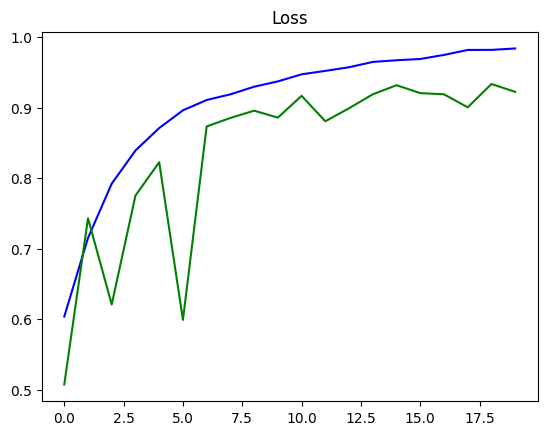

In [73]:
def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    #plt.ylim(0,ylim)
    plt.plot(history.history[metric_name],color='blue',label=metric_name)
    plt.plot(history.history['val_' + metric_name],color='green',label='val_' + metric_name)


plot_metrics(metric_name='accuracy', title="Loss", ylim=0.2)


## Test with xmodel


In [28]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import *

class ResNetBlockLayer(Layer):

  def __init__(self, out_channels, first_stride=1):
    super().__init__()

    first_padding = 'same'
    if first_stride != 1:
      first_padding = 'valid'

    self.conv_sequence = Sequential([
                            Conv2D(out_channels, 3,
                                   first_stride, padding=first_padding),
                            BatchNormalization(),
                            ReLU(),

                            Conv2D(out_channels, 3,
                                   1, padding='same'),
                            BatchNormalization(),
                            ReLU()
    ])

  def call(self, inputs):
    x = self.conv_sequence(inputs)

    if x.shape == inputs.shape:
      x = x + inputs
    return x

layer = ResNetBlock(4)
print(layer)

In [29]:
class ResNetX(Model):
  def __init__(self):
    super(ResNetX, self).__init__()

    self.conv_1 = Sequential([Conv2D(64, 7, 2),
                              ReLU(),
                              MaxPooling2D(3, 2)
                  ])

    self.resnet_chains = Sequential([ResNetBlockLayer(64), ResNetBlockLayer(64)] +
                                    [ResNetBlockLayer(128, 2), ResNetBlockLayer(128)] +
                                    [ResNetBlockLayer(256, 2), ResNetBlockLayer(256)] +
                                    [ResNetBlockLayer(512, 2), ResNetBlockLayer(512)])

    self.out = Sequential([GlobalAveragePooling2D(),
                           Dense(1, activation='sigmoid')
    ])

  def call(self, x):
    x = self.conv_1(x)
    x = self.resnet_chains(x)
    x = self.out(x)
    return x

modelx = ResNetX()
print(modelx)

In [30]:
modelx.build(input_shape=(None,224,224,3))
modelx.summary()

Model: "res_net_x"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 54, 54, 64)        9472      
                                                                 
 sequential_9 (Sequential)   (None, 5, 5, 512)         11004672  
                                                                 
 sequential_10 (Sequential)  (None, 1)                 513       
                                                                 
Total params: 11014657 (42.02 MB)
Trainable params: 11006977 (41.99 MB)
Non-trainable params: 7680 (30.00 KB)
_________________________________________________________________


In [32]:
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.losses import BinaryCrossentropy

modelx.compile(loss=BinaryCrossentropy(),
              optimizer=SGD(learning_rate=0.001),
              metrics=['accuracy']
              )

In [33]:
history_x = modelx.fit(train_batches,validation_data = validation_batches, epochs=20)

Epoch 1/20
582/582 [==============================] - 36s 55ms/step - loss: 0.6572 - accuracy: 0.6042 - val_loss: 0.6970 - val_accuracy: 0.5499
Epoch 2/20
582/582 [==============================] - 32s 54ms/step - loss: 0.6237 - accuracy: 0.6498 - val_loss: 1.1180 - val_accuracy: 0.5413
Epoch 3/20
582/582 [==============================] - 32s 54ms/step - loss: 0.5935 - accuracy: 0.6838 - val_loss: 0.8157 - val_accuracy: 0.5675
Epoch 4/20
582/582 [==============================] - 32s 54ms/step - loss: 0.5653 - accuracy: 0.7030 - val_loss: 0.6723 - val_accuracy: 0.6204
Epoch 5/20
582/582 [==============================] - 32s 54ms/step - loss: 0.5332 - accuracy: 0.7309 - val_loss: 0.5992 - val_accuracy: 0.6896
Epoch 6/20
582/582 [==============================] - 31s 54ms/step - loss: 0.5002 - accuracy: 0.7545 - val_loss: 0.6734 - val_accuracy: 0.6535
Epoch 7/20
582/582 [==============================] - 31s 53ms/step - loss: 0.4740 - accuracy: 0.7734 - val_loss: 1.2662 - val_accuracy: